In [6]:
'''install VADER to be used for sentiment analysis'''
! pip install vaderSentiment pandas_datareader textblob

You should consider upgrading via the 'C:\Users\vipul\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

import os
import re
import io
import nltk
import json

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn import preprocessing
from time import sleep
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

#pull the price data from yahoo finance
crypto_currency = 'BTC'
against_currency = 'USD'
start = dt.datetime(2021, 2, 6)
end = dt.datetime.now()
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
tweets_raw_file   = 'Bitcoin_tweets.csv'
tweets_clean_file = 'Bitcoin_tweets_clean.csv'

In [4]:
#load the raw tweets data in dataframe
df_raw = pd.read_csv(tweets_raw_file,low_memory=False)
print(df_raw.shape)
df_raw.head(5)

(3840626, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [5]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|█████████████████████████████████████████████████████████████████████████| 38406/38406 [00:02<00:00, 18730.14it/s]


In [ ]:
df_clean = pd.read_csv(tweets_clean_file)

analyzer = SentimentIntensityAnalyzer()
compound = []
#get the vader sentiment compound score
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(2)

100%|██████████| 457407/457407 [01:37<00:00, 4696.34it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,21514,TOP AIM STOCKS,United Kingdom,2021 stocks NEW CHANNEL https://t.co/I323dIOkP...,2015-05-31 20:20:57,16546.0,224.0,71404.0,False,2021-02-05 10:58:47,"Bitcoin braces for $48,000 as inverse head-and...","['Bitcoin', 'BTC']",Twitter Web App,False,0.4019
1,21509,Iconic Funds,"Frankfurt, Germany",Professional Crypto Asset Management\nhttps://...,2017-08-03 10:44:25,16813.0,818.0,1201.0,False,2021-02-05 11:00:21,📖 Weekend Read 📖\n\nKeen to learn about crypt...,['crypto'],Twitter Web App,False,0.4939


In [ ]:
scores = []
# modify sentiment score from vader compound score based on followers, likes and retweets
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(2)

100%|██████████| 457407/457407 [00:33<00:00, 13603.33it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,21514,TOP AIM STOCKS,United Kingdom,2021 stocks NEW CHANNEL https://t.co/I323dIOkP...,2015-05-31 20:20:57,16546.0,224.0,71404.0,False,2021-02-05 10:58:47,"Bitcoin braces for $48,000 as inverse head-and...","['Bitcoin', 'BTC']",Twitter Web App,False,0.4019,28695.935187
1,21509,Iconic Funds,"Frankfurt, Germany",Professional Crypto Asset Management\nhttps://...,2017-08-03 10:44:25,16813.0,818.0,1201.0,False,2021-02-05 11:00:21,📖 Weekend Read 📖\n\nKeen to learn about crypt...,['crypto'],Twitter Web App,False,0.4939,593.632492


# Read Bitcoin price 

In [ ]:
#not able to pull price data from yahoo finance in colab so pulled locally and uploaded as csv file
data = pd.read_csv("btc_price.csv")
data.Date = pd.to_datetime(data.Date)
data.set_index("Date", inplace = True)

In [ ]:
# sentiment analysis: group data to plot graphs
df_clean = df_clean.drop_duplicates()
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True, errors='coerce')
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

crypto_usd = data
# crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
# crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

In [ ]:
tweets.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
date,,,,,,,,,,,,,,,,
2021-02-05 10:58:47,21514,TOP AIM STOCKS,United Kingdom,2021 stocks NEW CHANNEL https://t.co/I323dIOkP...,2015-05-31 20:20:57,16546.0,224.0,71404.0,False,2021-02-05 10:58:47,"Bitcoin braces for $48,000 as inverse head-and...","['Bitcoin', 'BTC']",Twitter Web App,False,0.4019,28695.935187
2021-02-05 11:00:21,21509,Iconic Funds,"Frankfurt, Germany",Professional Crypto Asset Management\nhttps://...,2017-08-03 10:44:25,16813.0,818.0,1201.0,False,2021-02-05 11:00:21,📖 Weekend Read 📖\n\nKeen to learn about crypt...,['crypto'],Twitter Web App,False,0.4939,593.632492
2021-02-05 11:00:22,21508,Iconic Funds,"Frankfurt, Germany",Professional Crypto Asset Management\nhttps://...,2017-08-03 10:44:25,16813.0,818.0,1201.0,False,2021-02-05 11:00:22,2⃣ Debunking 9 Bitcoin Myths by ⬇️ \n\ncryp...,"['Bitcoin', 'cryptocurrency', 'bitcoin', 'cryp...",Twitter Web App,False,0.0000,0.000000
2021-02-05 11:00:24,21506,Iconic Funds,"Frankfurt, Germany",Professional Crypto Asset Management\nhttps://...,2017-08-03 10:44:25,16813.0,818.0,1201.0,False,2021-02-05 11:00:24,"5⃣ Blockchain 50 2021 by , , ⬇️\n\ncryptocur...","['Blockchain', 'cryptocurrency', 'bitcoin', 'c...",Twitter Web App,False,0.0000,0.000000
2021-02-05 11:00:24,21507,Iconic Funds,"Frankfurt, Germany",Professional Crypto Asset Management\nhttps://...,2017-08-03 10:44:25,16813.0,818.0,1201.0,False,2021-02-05 11:00:24,4⃣ 🎙️ Bloomberg LP CryptoOutlook 2021 with ⬇️...,"['CryptoOutlook', 'cryptocurrency', 'bitcoin',...",Twitter Web App,False,0.0000,0.000000


In [ ]:
tweets_grouped.head()

,index,user_followers,user_friends,user_favourites,user_verified,is_retweet,compound,score
date,,,,,,,,
2021-02-05 10:00:00,21514,16546.0,224.0,71404.0,0,0,0.4019,28695.935187
2021-02-05 11:00:00,257826,172107.0,40562.0,184797.0,0,0,1.5081,32399.195569
2021-02-05 12:00:00,448248,410959.0,142410.0,427146.0,1,0,5.6415,97405.269052
2021-02-05 13:00:00,275844,259836.0,118740.0,699734.0,0,0,0.1151,39115.818539
2021-02-05 14:00:00,316136,214631.0,70688.0,393887.0,0,0,1.8157,15379.695672


In [ ]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']
# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [ ]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

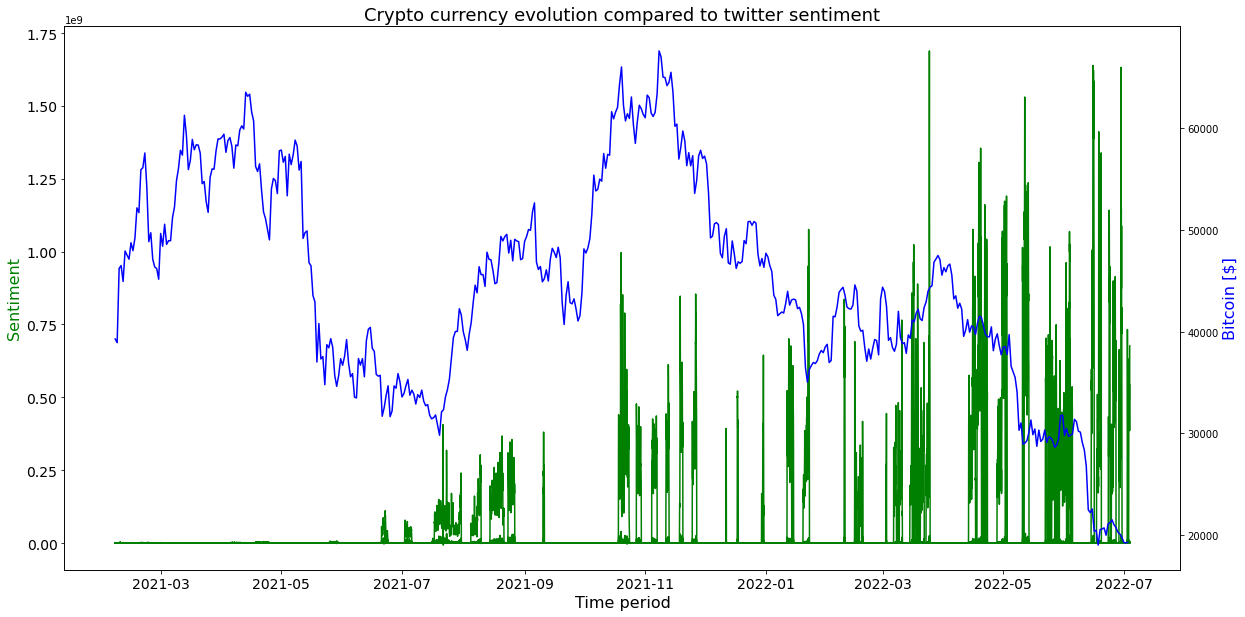

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()
plt.savefig('crypto_evolution_vs_twitter_sentiment', dpi=1000)

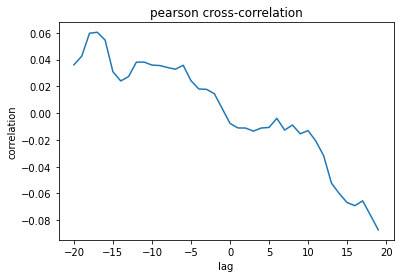

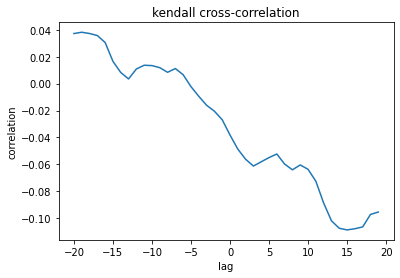

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


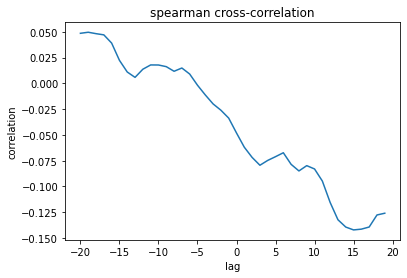

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Normalization

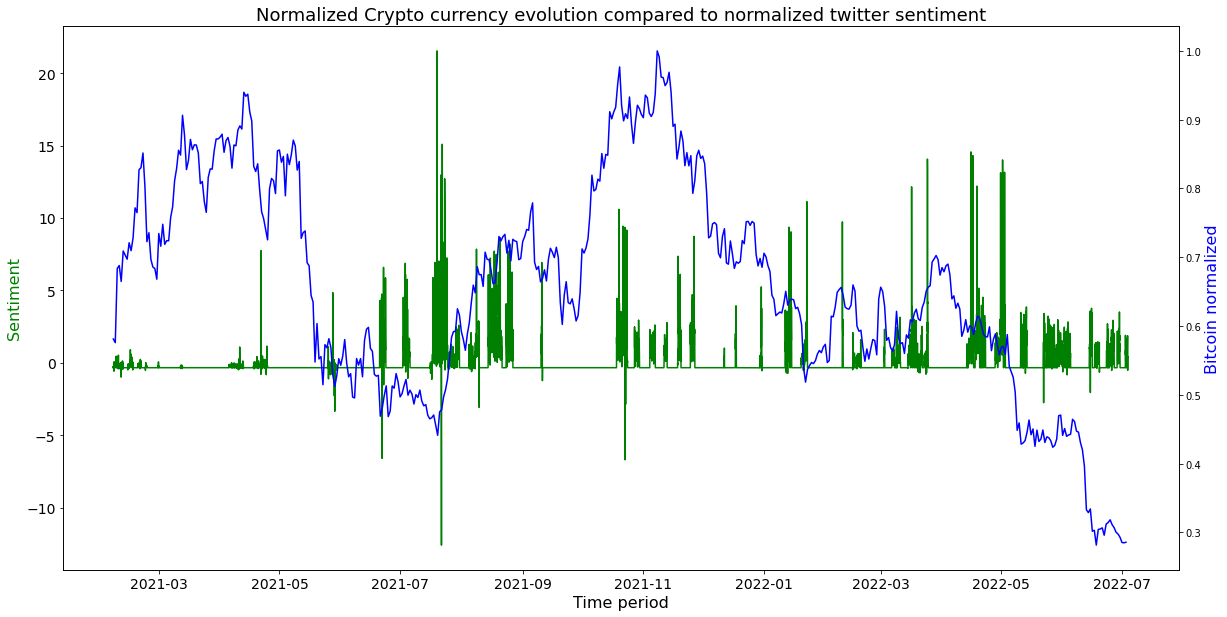

<Figure size 432x288 with 0 Axes>

In [ ]:
# Normalize sentiment scores and btc price
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()
plt.savefig('normalized_crypto_evolution_vs_twitter_sentiment', dpi=1000)

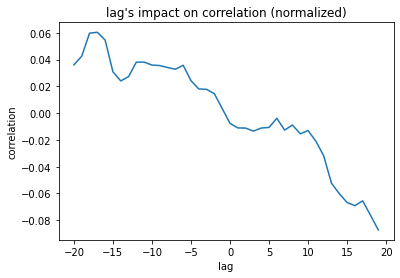

In [ ]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative of Crypto price 

In [ ]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

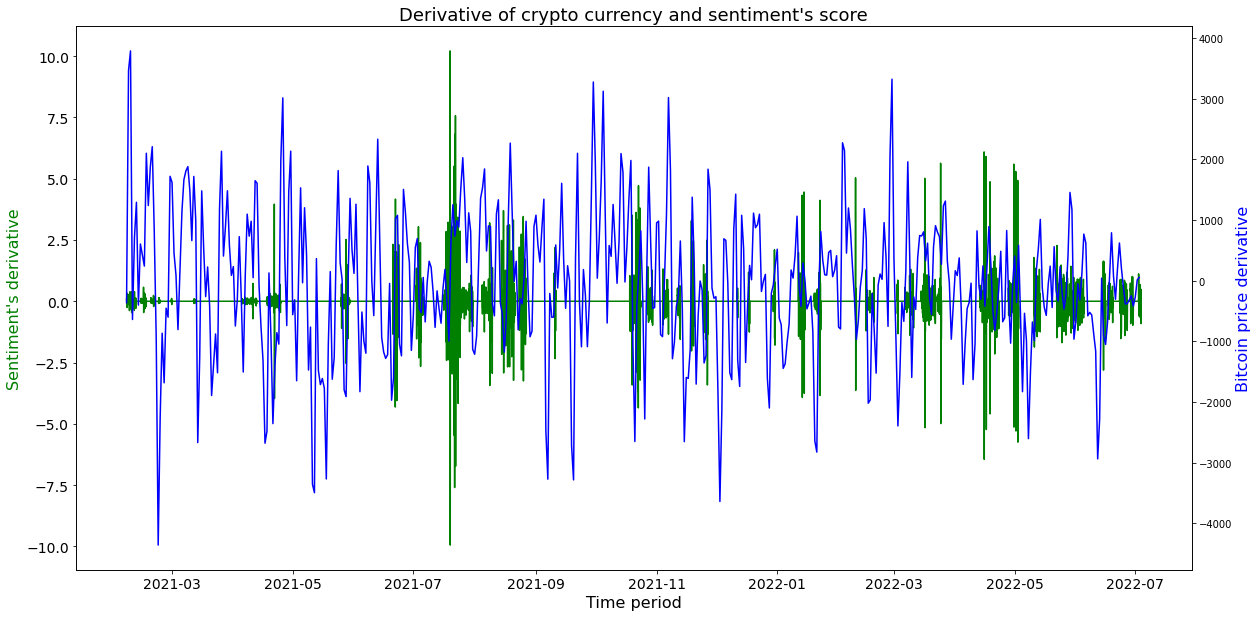

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.set_xlabel("Time period", fontsize=16)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()
plt.savefig('derivative_crypto_currency_vs_twitter_sentiment', dpi=1000)

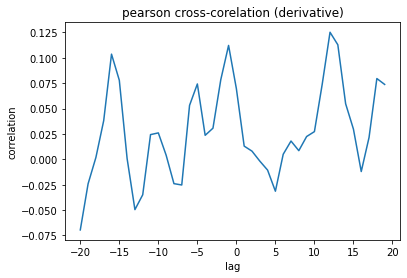

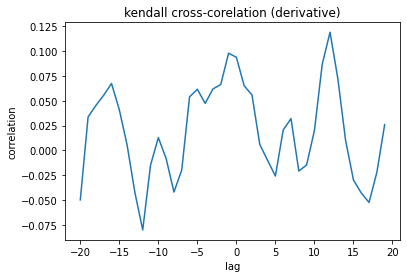

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


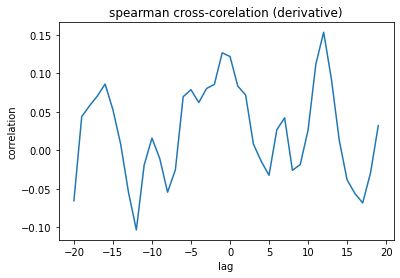

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

# NLP Modeling 

In [ ]:
df = df_clean.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,"Bitcoin braces for $48,000 as inverse head-and..."
1,📖 Weekend Read 📖\n\nKeen to learn about crypt...
2,2⃣ Debunking 9 Bitcoin Myths by ⬇️ \n\ncryp...
3,"5⃣ Blockchain 50 2021 by , , ⬇️\n\ncryptocur..."
4,4⃣ 🎙️ Bloomberg LP CryptoOutlook 2021 with ⬇️...


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Package punkt is already up-to-date!


In [ ]:
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce' ).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()


,tweets,cleaned_tweets,date_clean
0,"Bitcoin braces for $48,000 as inverse head-and...",Bitcoin brace inverse head shoulder favor BTC ...,2021-02-05
1,📖 Weekend Read 📖\n\nKeen to learn about crypt...,Weekend Read Keen learn crypto asset Check wee...,2021-02-05
2,2⃣ Debunking 9 Bitcoin Myths by ⬇️ \n\ncryp...,Debunking Bitcoin Myths cryptocurrency bitcoin...,2021-02-05
3,"5⃣ Blockchain 50 2021 by , , ⬇️\n\ncryptocur...",Blockchain cryptocurrency bitcoin crypto block...,2021-02-05
4,4⃣ 🎙️ Bloomberg LP CryptoOutlook 2021 with ⬇️...,Bloomberg LP CryptoOutlook cryptocurrency bitc...,2021-02-05


In [ ]:
df.shape

(457407, 3)

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.shape

(457407, 3)

In [ ]:
# function to get polarity using the Textblob library
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [ ]:
# create price target
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
def observe_period(period):
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    res = res.apply(crypto_price_cate)
    return res 

time_sentiment = observe_period(20) # compare price ratio in 20 days. price_20_days_later/ price_now 
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [ ]:
# may takes time 
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head(20)

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,"Bitcoin braces for $48,000 as inverse head-and...",Bitcoin brace inverse head shoulder favor BTC ...,2021-02-05,NaN,0.000,0.000000
1,📖 Weekend Read 📖\n\nKeen to learn about crypt...,Weekend Read Keen learn crypto asset Check wee...,2021-02-05,NaN,0.000,0.000000
2,2⃣ Debunking 9 Bitcoin Myths by ⬇️ \n\ncryp...,Debunking Bitcoin Myths cryptocurrency bitcoin...,2021-02-05,NaN,0.000,0.000000
3,"5⃣ Blockchain 50 2021 by , , ⬇️\n\ncryptocur...",Blockchain cryptocurrency bitcoin crypto block...,2021-02-05,NaN,0.000,0.000000
4,4⃣ 🎙️ Bloomberg LP CryptoOutlook 2021 with ⬇️...,Bloomberg LP CryptoOutlook cryptocurrency bitc...,2021-02-05,NaN,0.000,0.000000
5,"Analyst Says bitcoin Likely Reach $60,000 in Q...",Analyst Says bitcoin Likely Reach Q btc coinsp...,2021-02-05,NaN,1.000,0.000000
6,To-do or not To-do. crypto btc Bitcoin Ether...,To To crypto btc Bitcoin Ethereum qZvYmBEZ,2021-02-05,NaN,0.000,0.000000
7,Twitter CEO Jack Dorsey has fired up a full Bi...,Twitter CEO Jack Dorsey fired full Bitcoin nod...,2021-02-05,NaN,0.550,0.350000
8,"Bitcoin and traditional assets, can there be a...",Bitcoin traditional asset ideal mix one portfo...,2021-02-05,NaN,0.875,0.450000
9,"/XRKGaKgDCP\n\nMarketing – weekly services, CR...",XRKGaKgDCP Marketing weekly service CRM accept...,2021-02-05,NaN,0.000,0.000000


In [ ]:
df["crypto_sentiment"].value_counts()

positive    285326
negative    171873
Name: crypto_sentiment, dtype: int64

In [ ]:
# create sentiment labels
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()
df.to_csv('./df_data.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


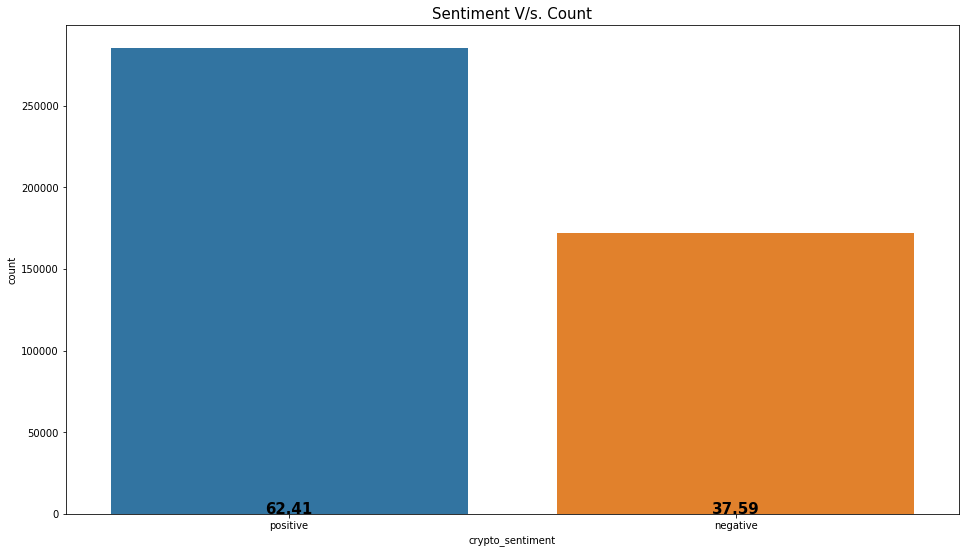

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
plt.figure(figsize=[16,9])
sns.countplot(df.crypto_sentiment)
plt.title('Sentiment V/s. Count', fontsize=15)

label = (df.crypto_sentiment.value_counts(normalize=True)*100).round(2)
for i in range(2):
    plt.text(x = i, y = label[i], s = label[i],horizontalalignment='center',rotation = 360, color = "black", weight="bold", fontsize=15)

plt.legend
plt.show()
plt.savefig('sentiment_vs_count', dpi=1000)

In [ ]:
# plt.figure(figsize=(14,10))

# for i in range(df.shape[0]):
#     plt.scatter(df["polarity"].iloc[[i]].values[0], df["subjectivity"].iloc[[i]].values[0], color="Purple")

# plt.title("Sentiment Analysis Scatter Plot")
# plt.xlabel('polarity')
# plt.ylabel('subjectivity')
# plt.show()

# Model preparation 

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.backend as K
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,"Bitcoin braces for $48,000 as inverse head-and...",Bitcoin brace inverse head shoulder favor BTC ...,2021-02-05,NaN,0.0,0.0,neutral,False
1,📖 Weekend Read 📖\n\nKeen to learn about crypt...,Weekend Read Keen learn crypto asset Check wee...,2021-02-05,NaN,0.0,0.0,neutral,False
2,2⃣ Debunking 9 Bitcoin Myths by ⬇️ \n\ncryp...,Debunking Bitcoin Myths cryptocurrency bitcoin...,2021-02-05,NaN,0.0,0.0,neutral,False
3,"5⃣ Blockchain 50 2021 by , , ⬇️\n\ncryptocur...",Blockchain cryptocurrency bitcoin crypto block...,2021-02-05,NaN,0.0,0.0,neutral,False
4,4⃣ 🎙️ Bloomberg LP CryptoOutlook 2021 with ⬇️...,Bloomberg LP CryptoOutlook cryptocurrency bitc...,2021-02-05,NaN,0.0,0.0,neutral,False


In [ ]:
df.shape

(457407, 8)

In [ ]:
# model will be trained on tweet text and sentiment labels will be used as target
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [ ]:
seed = 38 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(365925,) (91482,) (365925, 3) (91482, 3)


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(365925, 30) (91482, 30)


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

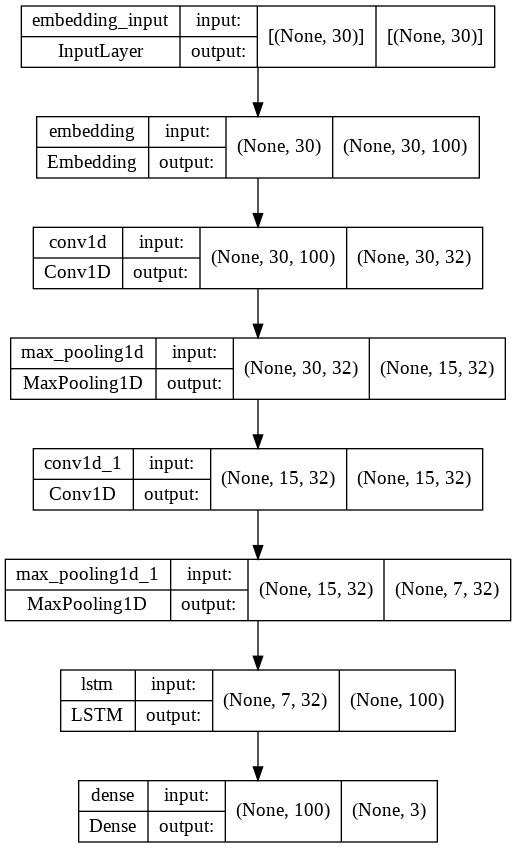

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
2859/2859 - 178s - loss: 0.1401 - accuracy: 0.9539 - val_loss: 0.0737 - val_accuracy: 0.9792 - 178s/epoch - 62ms/step
Epoch 2/10
2859/2859 - 171s - loss: 0.0582 - accuracy: 0.9834 - val_loss: 0.0659 - val_accuracy: 0.9813 - 171s/epoch - 60ms/step
Epoch 3/10
2859/2859 - 173s - loss: 0.0443 - accuracy: 0.9874 - val_loss: 0.0685 - val_accuracy: 0.9814 - 173s/epoch - 61ms/step
Epoch 4/10
2859/2859 - 170s - loss: 0.0352 - accuracy: 0.9899 - val_loss: 0.0722 - val_accuracy: 0.9808 - 170s/epoch - 60ms/step
Epoch 5/10
2859/2859 - 170s - loss: 0.0281 - accuracy: 0.9917 - val_loss: 0.0812 - val_accuracy: 0.9804 - 170s/epoch - 59ms/step
Epoch 6/10
2859/2859 - 169s - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0778 - val_accuracy: 0.9802 - 169s/epoch - 59ms/step
Epoch 7/10
2859/2859 - 168s - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0888 - val_accuracy: 0.9801 - 168s/epoch - 59ms/step
Epoch 8/10
2859/2859 - 167s - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0943 - val_accuracy: 

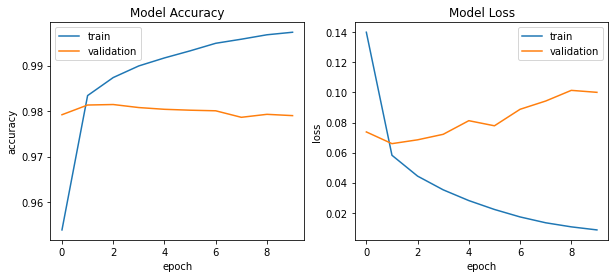

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
    plt.savefig("train_accuracy_loss", dpi=1000)
    
plot_training_hist(history)

In [ ]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	97.9%
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     11427
           1       0.99      0.99      0.99     38470
           2       0.98      0.98      0.98     41585

    accuracy                           0.98     91482
   macro avg       0.97      0.97      0.97     91482
weighted avg       0.98      0.98      0.98     91482



2    41585
1    38470
0    11427
dtype: int64
2    41497
1    38706
0    11279
dtype: int64


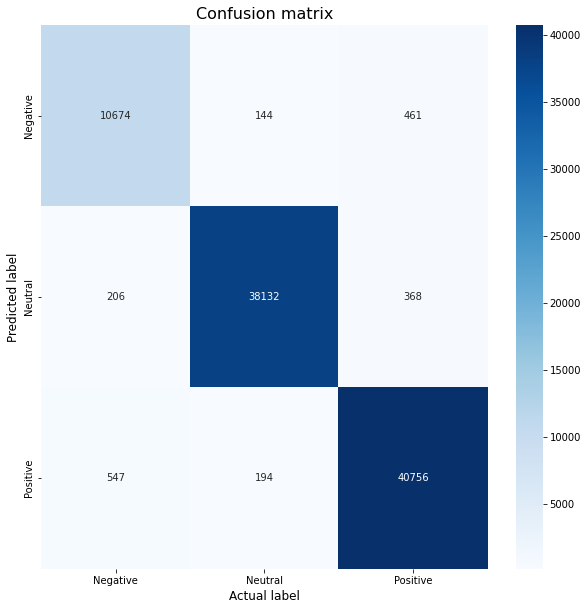

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.savefig("train_matrix", dpi=1000)
    
plot_confusion_matrix(model, X_test, y_test)

### Price Movement Prediction

In [ ]:
df1 = df.dropna()

In [ ]:
df1.shape

(457199, 8)

In [ ]:
df1.crypto_sentiment.value_counts()

positive    285326
negative    171873
Name: crypto_sentiment, dtype: int64

In [ ]:
X = df1['cleaned_tweets']
y = pd.get_dummies(df1['crypto_sentiment']).values
num_classes = df1['crypto_sentiment'].nunique()

In [ ]:
seed = 38 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(365759,) (91440,) (365759, 2) (91440, 2)


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(365759, 30) (91440, 30)


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

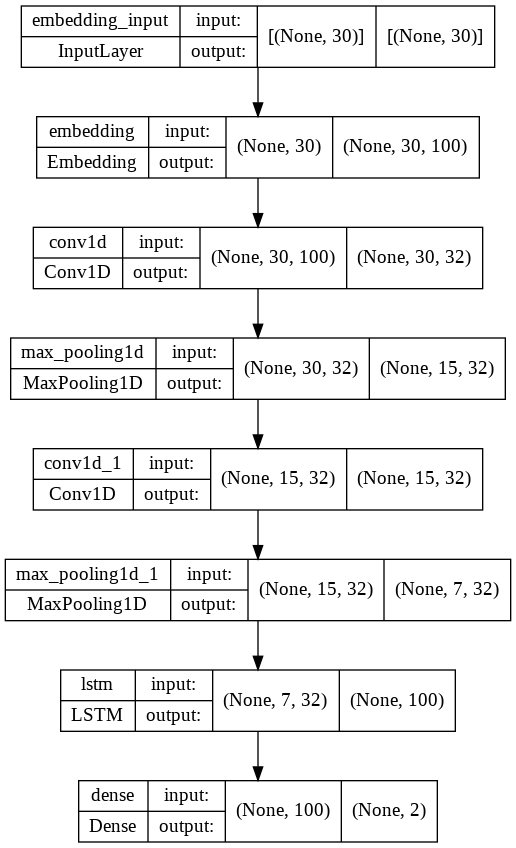

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [175]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
2858/2858 - 195s - loss: 0.5701 - accuracy: 0.6880 - val_loss: 0.5458 - val_accuracy: 0.7061 - 195s/epoch - 68ms/step
Epoch 2/10
2858/2858 - 189s - loss: 0.5057 - accuracy: 0.7321 - val_loss: 0.5461 - val_accuracy: 0.7054 - 189s/epoch - 66ms/step
Epoch 3/10
2858/2858 - 187s - loss: 0.4369 - accuracy: 0.7786 - val_loss: 0.5718 - val_accuracy: 0.6993 - 187s/epoch - 66ms/step
Epoch 4/10
2858/2858 - 186s - loss: 0.3595 - accuracy: 0.8260 - val_loss: 0.6562 - val_accuracy: 0.6857 - 186s/epoch - 65ms/step
Epoch 5/10
2858/2858 - 185s - loss: 0.2959 - accuracy: 0.8606 - val_loss: 0.7470 - val_accuracy: 0.6916 - 185s/epoch - 65ms/step
Epoch 6/10
2858/2858 - 185s - loss: 0.2512 - accuracy: 0.8832 - val_loss: 0.8419 - val_accuracy: 0.6831 - 185s/epoch - 65ms/step
Epoch 7/10
2858/2858 - 185s - loss: 0.2188 - accuracy: 0.8988 - val_loss: 0.9069 - val_accuracy: 0.6913 - 185s/epoch - 65ms/step
Epoch 8/10
2858/2858 - 185s - loss: 0.1960 - accuracy: 0.9100 - val_loss: 1.0137 - val_accuracy: 

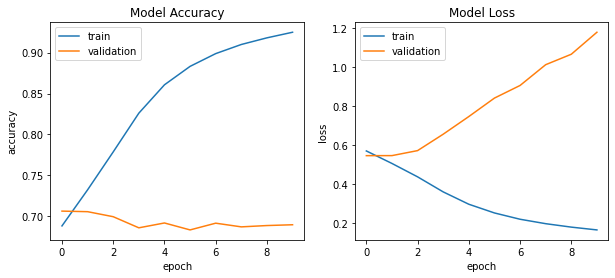

In [176]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
    plt.savefig("train_accuracy_loss", dpi=1000)
    
plot_training_hist(history)

In [177]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	68.9%
              precision    recall  f1-score   support

           0       0.60      0.50      0.55     34375
           1       0.73      0.80      0.76     57065

    accuracy                           0.69     91440
   macro avg       0.67      0.65      0.66     91440
weighted avg       0.68      0.69      0.68     91440



1    57065
0    34375
dtype: int64
1    62727
0    28713
dtype: int64


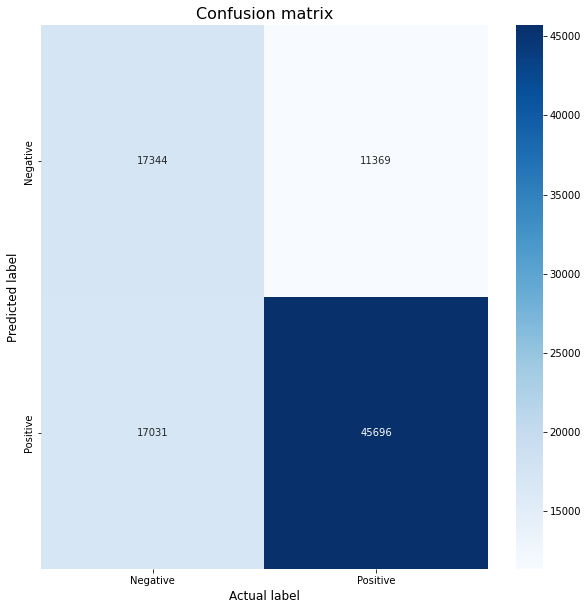

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.savefig("train_matrix", dpi=1000)
    
plot_confusion_matrix(model, X_test, y_test)